# import

In [12]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os
import pickle

In [13]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# functions

In [14]:
def checks(alledges,allnodes):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first

    ### for now let's just remove the couplers associated with the missing qubits
    missingqcoups=[]
    for missingq in missingqs:
        for coup in missingcoups:
            if (coup[0]==missingq or coup[1]==missingq):
                missingqcoups.append(coup)
#     print("coups associated with missing qubits",missingqcoups)
    for coup in missingqcoups:
#         print("removing",coup)
        missingcoups.remove(coup)
        edges_norepeats.remove(coup)


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        final_coups.update({edge:jafm})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    twochains = twochains + current_twochains
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

def checks_with_twochains(alledges,allnodes,current_twochains):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        if edge in current_twochains or Reverse(edge) in current_twochains:
            final_coups.update({edge:k2})
        else:
            final_coups.update({edge:jafm})
        
    #for the edges that are pre-defined two-chains:
    #for edge in current_twochains:
    #    final_coups.update({edge:k2})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    twochains = twochains + current_twochains
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo



def checks_and_do_nothing(alledges,allnodes,current_twochains):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    
    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        if edge in current_twochains or Reverse(edge) in current_twochains:
            final_coups.update({edge:k2})
        else:
            final_coups.update({edge:jafm})
    


    #make a list of the final nodes
    twochains = current_twochains
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

In [15]:
def set_hs(final_nodes,onechain_nodes,twochain_nodes,h1,h2):
    hdict={}
    for node in final_nodes:
        if node in onechain_nodes:
            hdict.update({node:h1})
        if node in twochain_nodes:
            hdict.update({node:h2})
        if (node in onechain_nodes and node in twochain_nodes):
            print("error")
    return hdict

def set_hs_with_edge(final_nodes,onechain_nodes,twochain_nodes, modifyer_groups, h1, new_h_groups):
    hdict={}
    for node in final_nodes:
        check = 0
        for i in range(len(new_h_groups)):
            if node in modifyer_groups[i]:
                check = 1
                new_h1 = new_h_groups[i]
                if node in onechain_nodes:
                    hdict.update({node:new_h1})
                elif node in twochain_nodes:
                    hdict.update({node:0.5*new_h1})
                elif (node in onechain_nodes and node in twochain_nodes):
                    print("error")
        if check == 0:
            if node in onechain_nodes:
                hdict.update({node:h1})
            elif node in twochain_nodes:
                hdict.update({node:0.5*h1})
            elif (node in onechain_nodes and node in twochain_nodes):
                print("error")
    return hdict

# extract the list of coups and nodes

In [16]:
with open('nodes_class.pkl', 'rb') as file:
    nodes_class = pickle.load(file)
with open('coups_class.pkl', 'rb') as file:
    coups_class = pickle.load(file)

In [58]:
final_coups_list = list(coups_class.keys())
twochains = []
edge_color_list = []
for item in final_coups_list:
    if coups_class[item] == 'K2':
        twochains.append(item)
        edge_color_list.append('blue')
    elif coups_class[item] == 'J11':
        edge_color_list.append('red')
    elif coups_class[item] == 'J12':
        edge_color_list.append('orange')
    elif coups_class[item] == 'J22':
        edge_color_list.append('red')

all_nodes = list(nodes_class.keys())
node_color_list = []
for node in sampler.nodelist:
    if node in all_nodes:
        index = sampler.nodelist.index(node)
        #these are onechains. They don't get any hoffset or anneal offset
        if nodes_class[node]=="BUL1":
            node_color_list.append('red')
        elif nodes_class[node]=="BSE1":
            node_color_list.append('red')
        elif nodes_class[node]=="EB1":
            node_color_list.append('red')

        #these are twochains. They get hoffsets and anneal offsets
        elif nodes_class[node]=="BUL2":
            node_color_list.append('blue')
        elif nodes_class[node]=="EA2":
            node_color_list.append('blue')
        elif nodes_class[node]=="EB2":
            node_color_list.append('blue')
    else:
        node_color_list.append('gray')


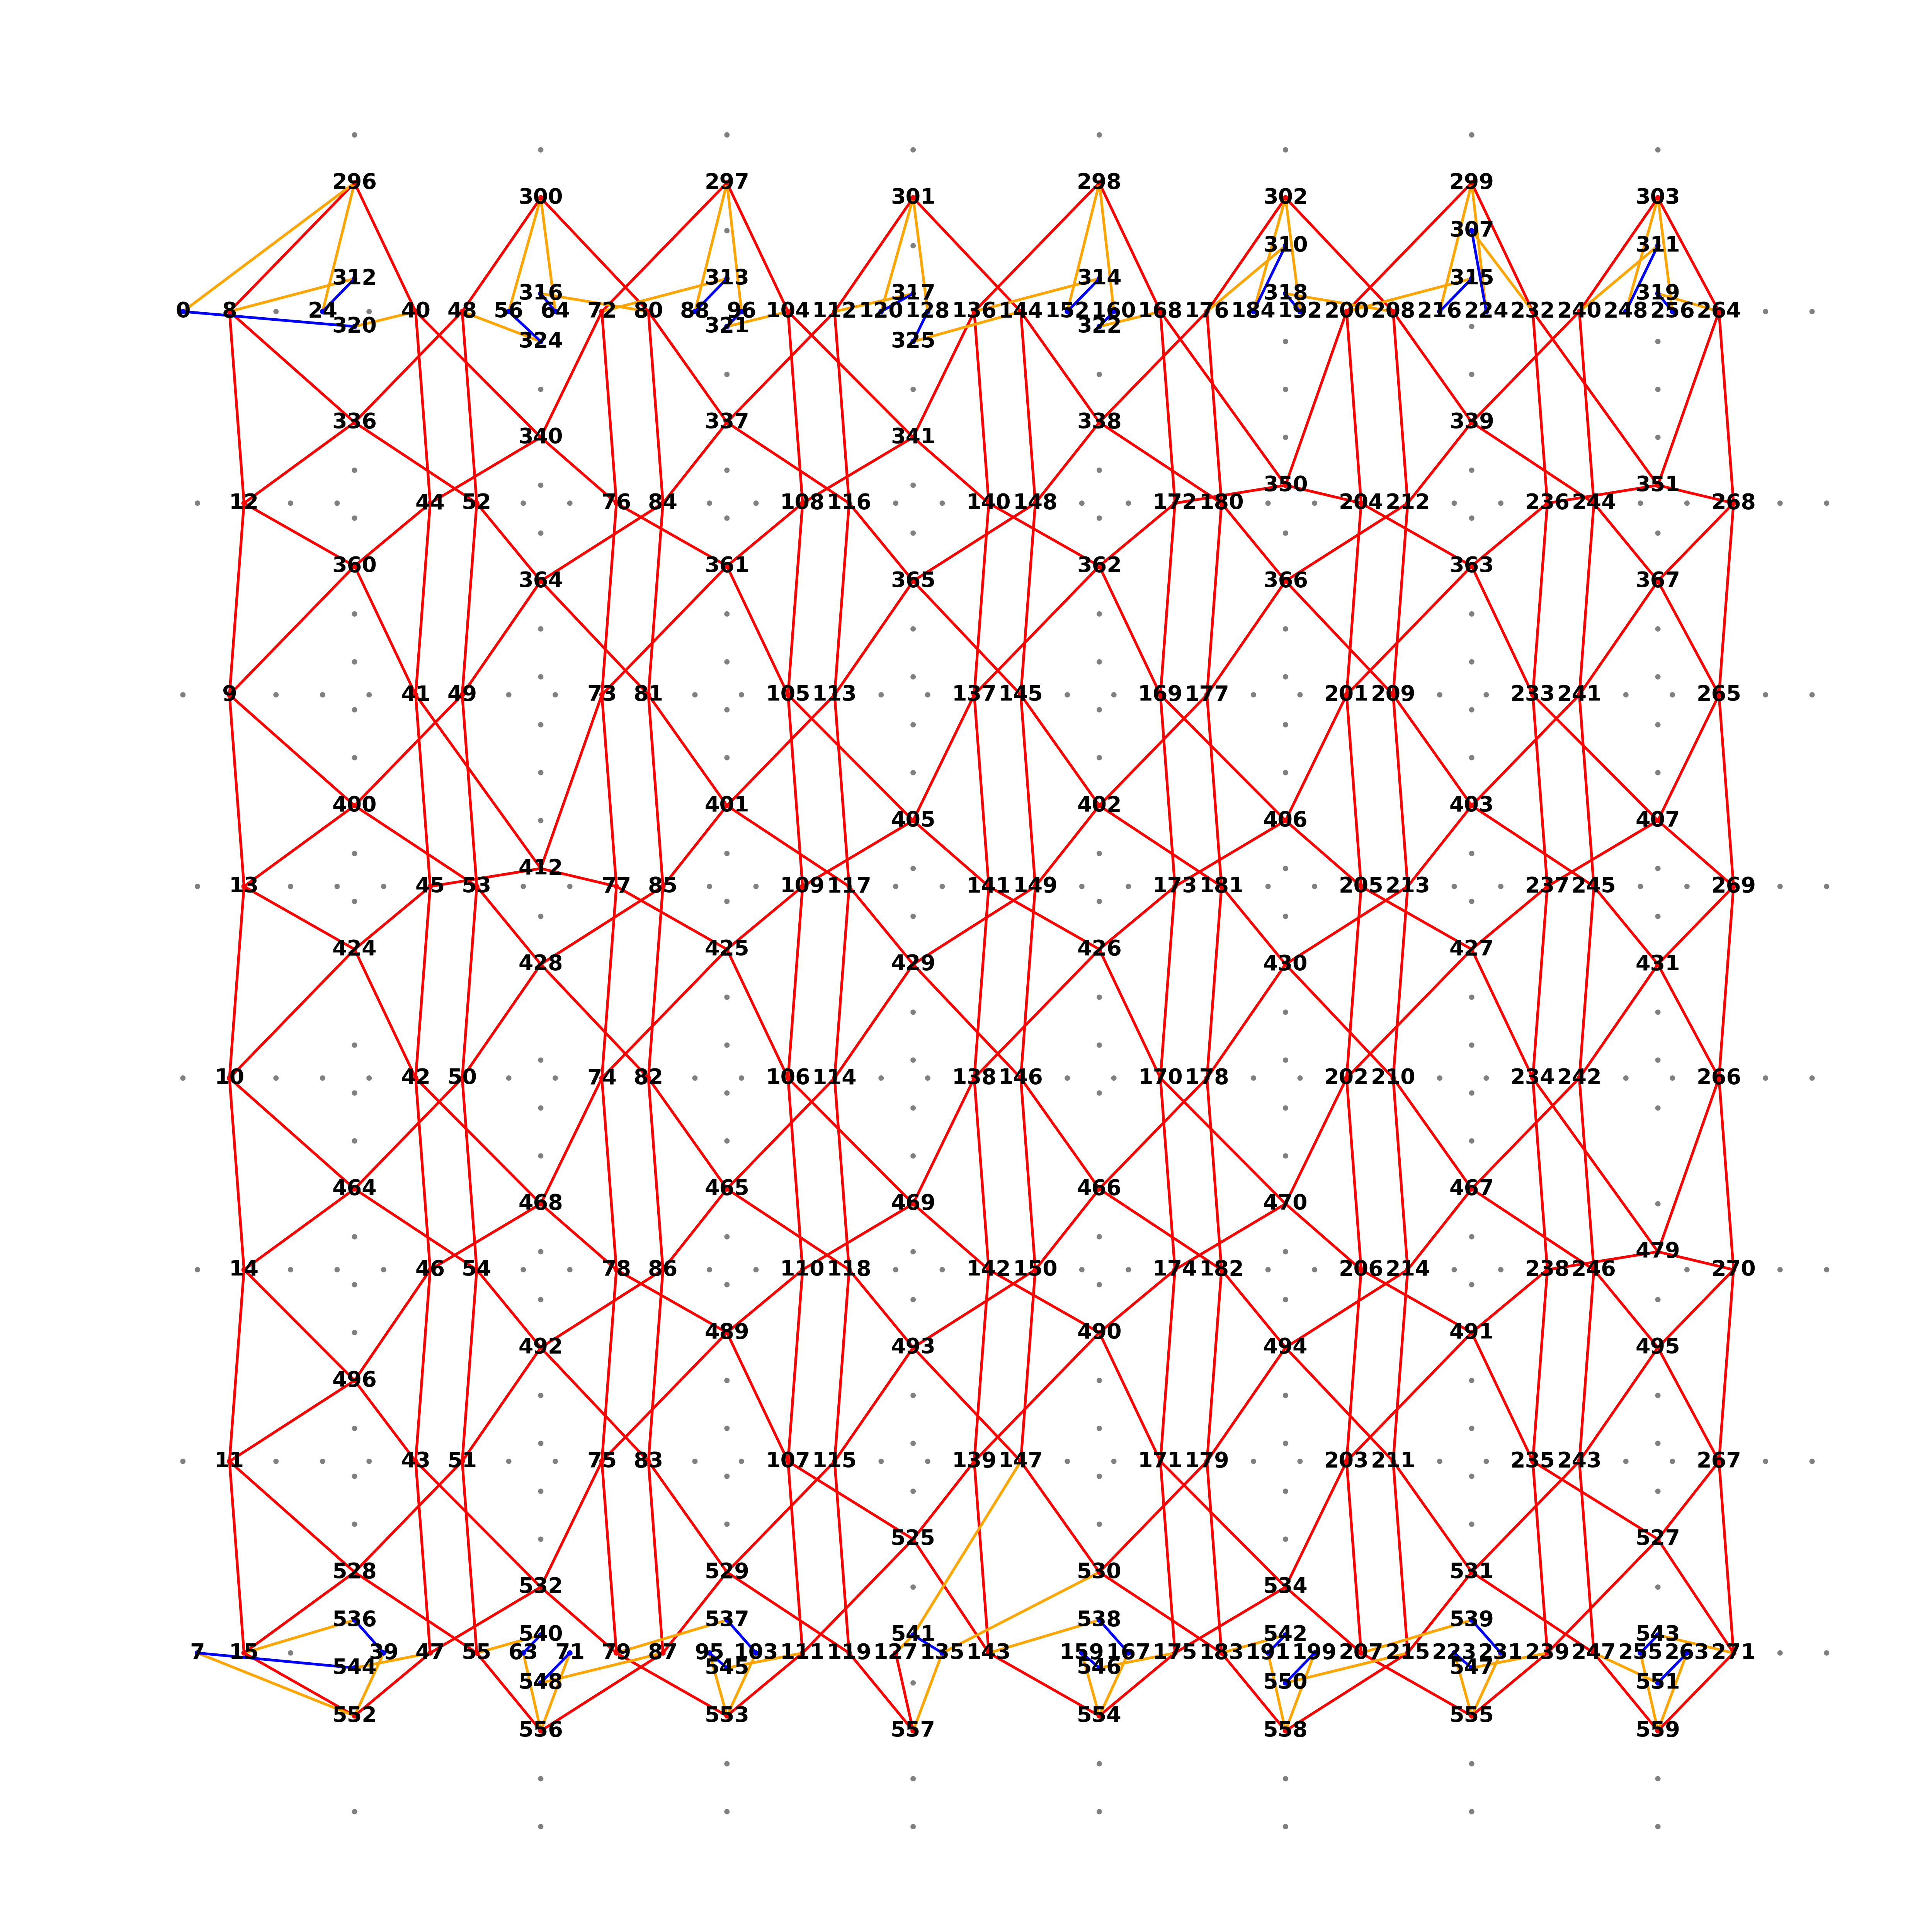

In [65]:
plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=500
G = dnx.zephyr_graph(4)
labels = {}
for qubit in sampler.nodelist:
    if qubit in all_nodes:
        labels.update({qubit:qubit})
    else:
        labels.update({qubit:""})
dnx.draw_zephyr(G, node_size = 1, edgelist = final_coups_list, 
nodelist = sampler.nodelist, font_size = 8, node_color = node_color_list, 
edge_color = edge_color_list,
labels = labels, font_weight = "bold")
plt.show()

# big plots of periodic lattice

In [19]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [56]:
#make a graph with majority rule, for the fourier transform. 
#for all pre-imposed two-chains, remove the second one, reconnect to other sites
#then cut open the periodic boundary condition
simplify_Kag_graph = nx.Graph()
# big_graph = Kag_periodic
# all_edges_kag = [e for e in big_graph.edges()] 
# all_nodes_kag = []
for m in nodes_class.keys():
    simplify_Kag_graph.add_node(m)
for e in coups_class.keys():
    simplify_Kag_graph.add_edge(*e)

#remove the end edges
# for e in all_edges_kag:
#     if e in to_add_edge:
#         simplify_Kag_graph.remove_edge(*e)
#     elif Reverse(e) in to_add_edge:
#         simplify_Kag_graph.remove_edge(*Reverse(e))

#remove the second site of the two chains, and replug the graph
to_remove = []
to_add = []
node_remove = []
for twoch in twochains:
    #print("treating this 2chain", twoch)
    node_remove.append(twoch[1])
    temp_edges_to_modify = simplify_Kag_graph.edges(twoch[1])
    #print(temp_edges_to_modify)
    for edge in temp_edges_to_modify:
        #print("Modifying this edges", edge)
        to_remove.append(edge)
        if edge != twoch and edge != Reverse(twoch):
            new_link = twoch[1]
            for m in range(2):
                if edge[m] != twoch[1]:
                    new_link = edge[m]
            edge_add = (twoch[0], new_link)
            to_add.append(edge_add)


simplify_Kag_graph.remove_edges_from(to_remove)
simplify_Kag_graph.add_edges_from(to_add)
simplify_Kag_graph.remove_nodes_from(node_remove)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
test, planar_embed = nx.check_planarity(simplify_Kag_graph)
pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10, iterations = 1000, pos = pos, scale = 10)
#pos=nx.spring_layout(simplify_Kag_graph, dim = 3, k=10,iterations = 1000, scale = 40)


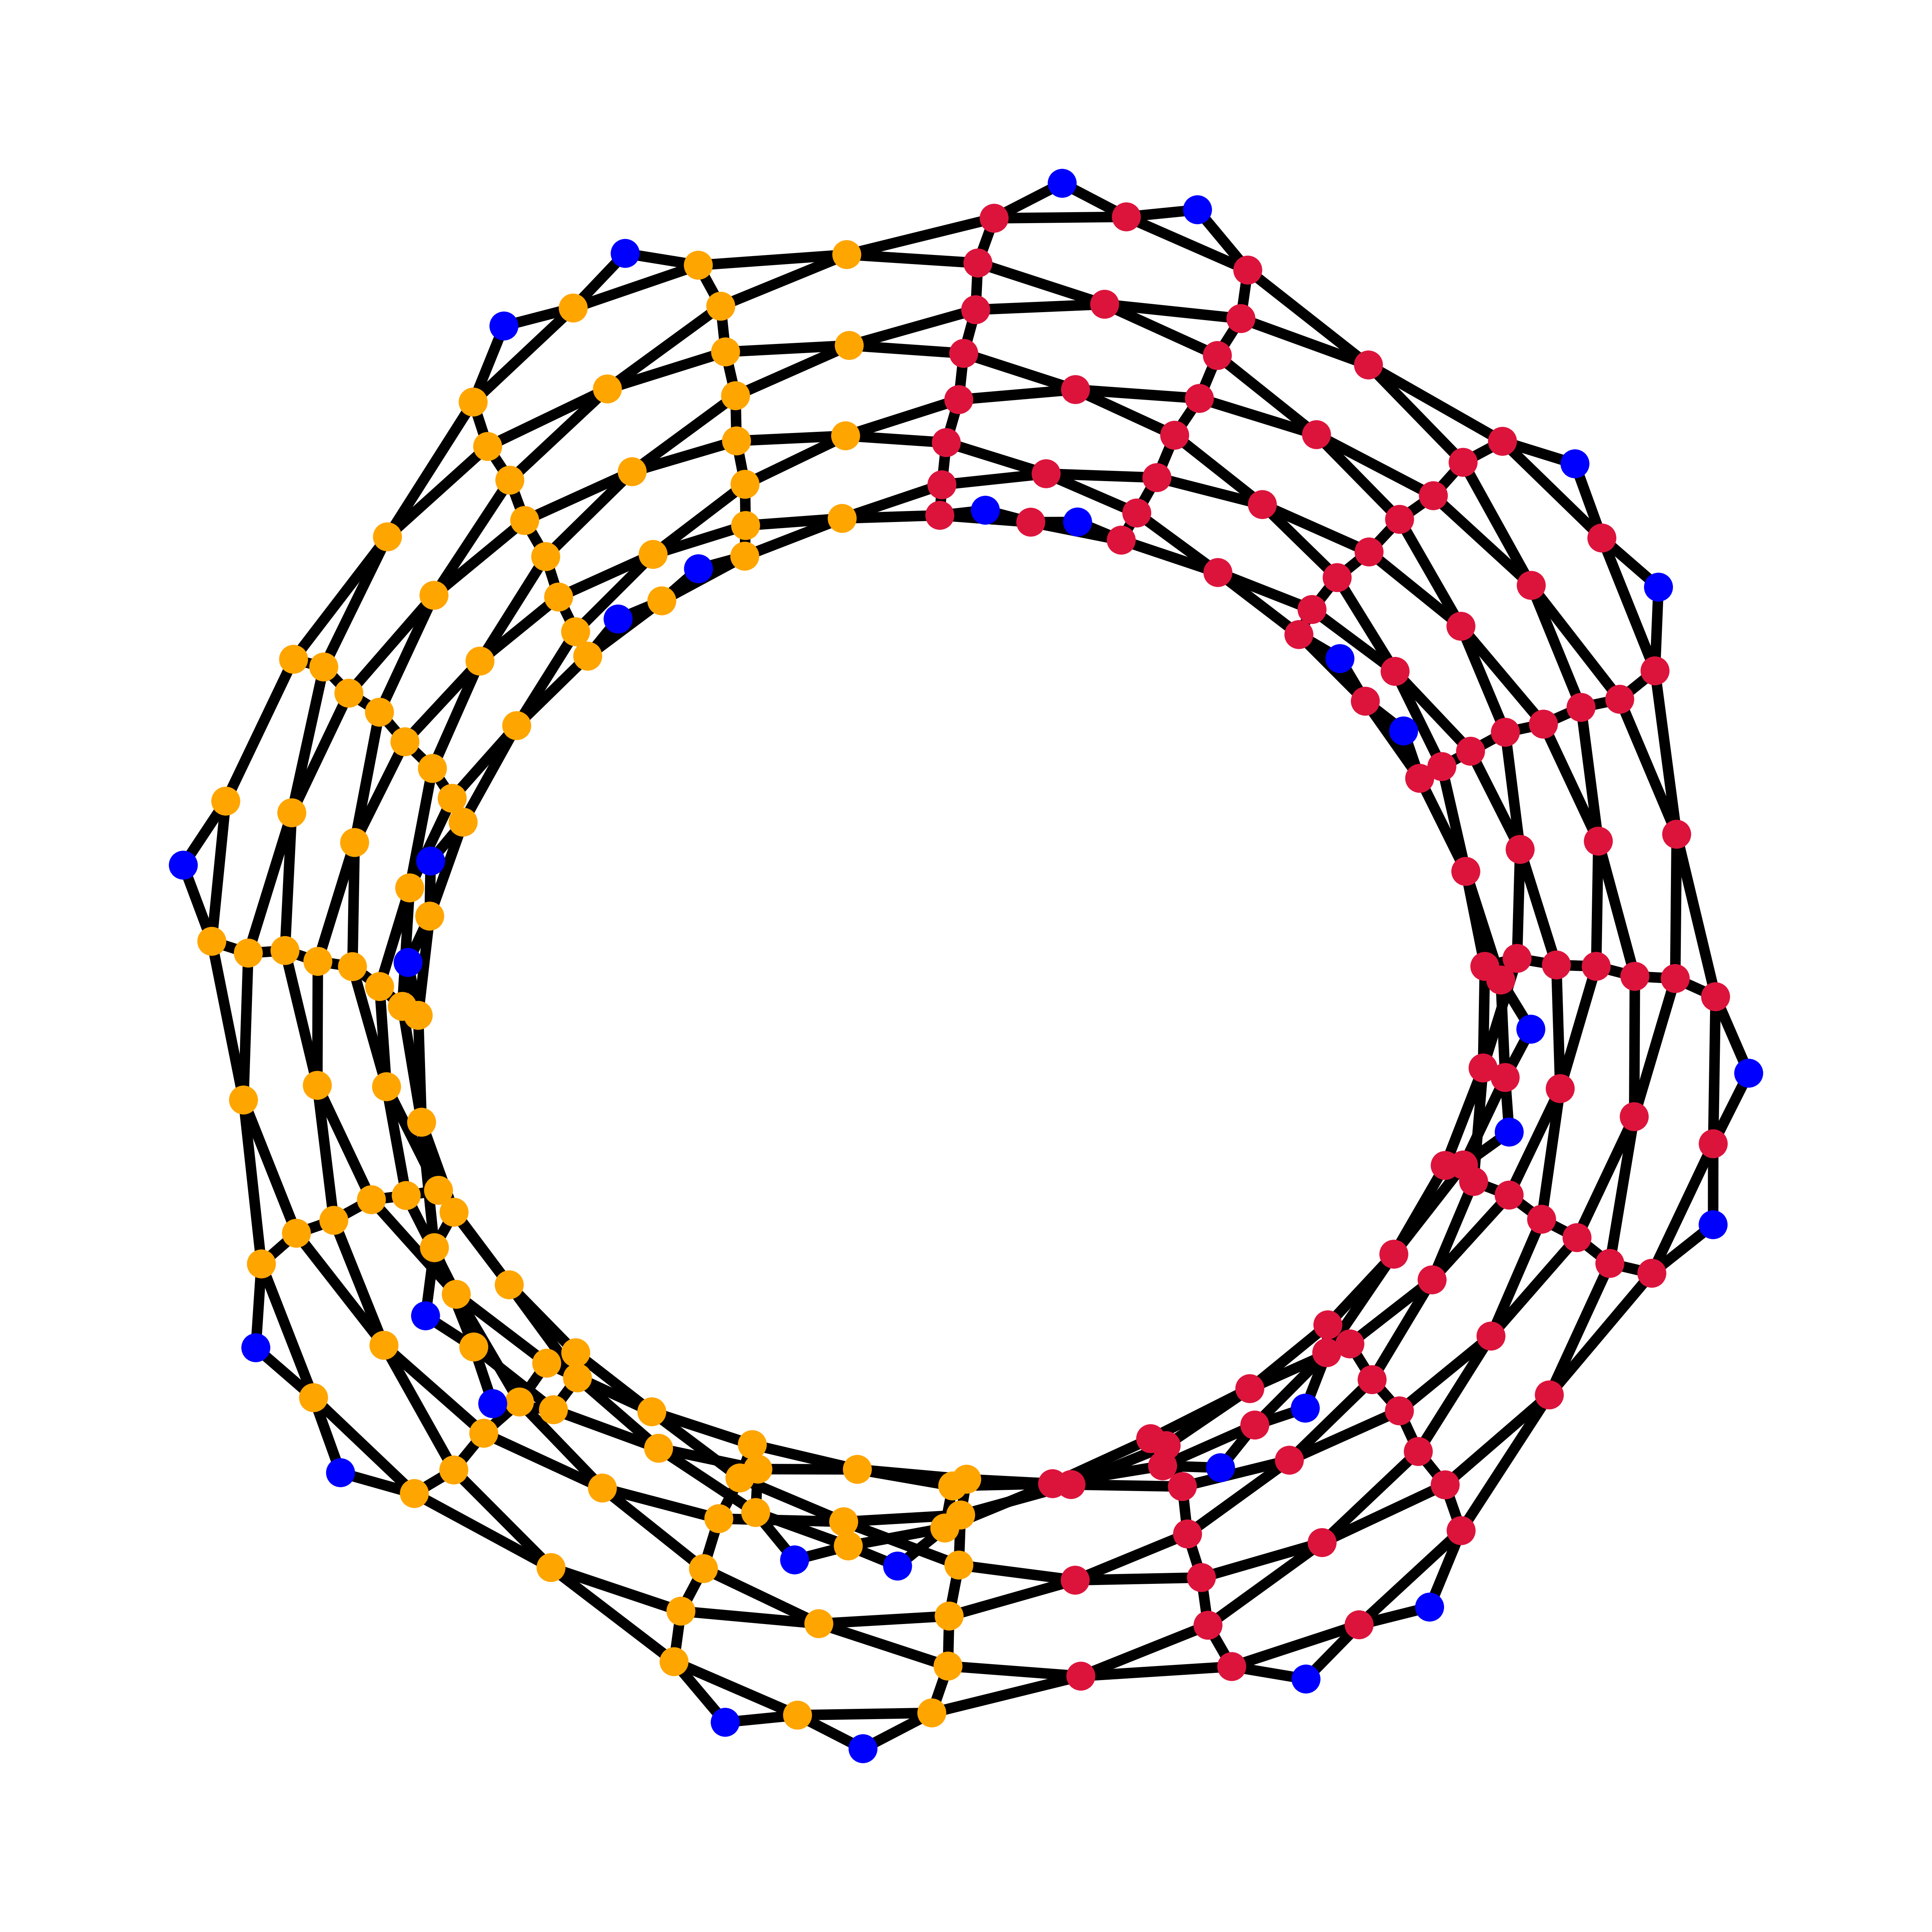

In [66]:
final_qubit_dictionary = np.load("./data/dict_qbit_to_lattice_periodic.npy", allow_pickle=True).tolist()
color_list = []
for key in simplify_Kag_graph.nodes():
    #print(final_qubit_dictionary[key][1])
    if final_qubit_dictionary[key][0] == 0 or final_qubit_dictionary[key][0] == 9.0:
        color_list.append("blue")
    else:
        if final_qubit_dictionary[key][1] > 13.5:
            color_list.append("orange")
        else:
            color_list.append("crimson")

nx.draw(simplify_Kag_graph, pos, node_size = 100, node_color = color_list, width = 4)


In [50]:
final_qubit_dictionary.tolist()

{536: array([0., 0.]),
 15: array([1., 0.]),
 11: array([2., 0.]),
 14: array([3., 0.]),
 10: array([4., 0.]),
 13: array([5., 0.]),
 9: array([6., 0.]),
 12: array([7., 0.]),
 8: array([8., 0.]),
 24: array([9., 0.]),
 552: array([0.5      , 0.8660254]),
 496: array([2.5      , 0.8660254]),
 424: array([4.5      , 0.8660254]),
 360: array([6.5      , 0.8660254]),
 296: array([8.5      , 0.8660254]),
 7: array([0.        , 1.73205081]),
 47: array([1.        , 1.73205081]),
 43: array([2.        , 1.73205081]),
 46: array([3.        , 1.73205081]),
 42: array([4.        , 1.73205081]),
 45: array([5.        , 1.73205081]),
 41: array([6.        , 1.73205081]),
 44: array([7.        , 1.73205081]),
 40: array([8.        , 1.73205081]),
 0: array([9.        , 1.73205081]),
 532: array([1.5       , 2.59807621]),
 468: array([3.5       , 2.59807621]),
 412: array([5.5       , 2.59807621]),
 340: array([7.5       , 2.59807621]),
 79: array([1.        , 3.46410162]),
 537: array([0.        ,

a 3D version of this

In [33]:
import plotly.graph_objects as go

G = simplify_Kag_graph

Num_nodes = len(G.nodes)

# plt.figure(figsize=(5,5))
edges = G.edges()

# ## update to 3d dimension
spring_3D = nx.spring_layout(G, dim = 3, iterations = 1000, scale = 40) # k regulates the distance between nodes
# weights = [G[u][v]['weight'] for u,v in edges]
# nx.draw(G, with_labels=True, node_color='skyblue', font_weight='bold',  width=weights, pos=pos)

# we need to seperate the X,Y,Z coordinates for Plotly
# NOTE: spring_3D is a dictionary where the keys are 1,...,6
x_nodes= [spring_3D[key][0] for key in spring_3D.keys()] # x-coordinates of nodes
y_nodes = [spring_3D[key][1] for key in spring_3D.keys()] # y-coordinates
z_nodes = [spring_3D[key][2] for key in spring_3D.keys()] # z-coordinates

#we need to create lists that contain the starting and ending coordinates of each edge.
x_edges=[]
y_edges=[]
z_edges=[]

#create lists holding midpoints that we will use to anchor text
xtp = []
ytp = []
ztp = []

#need to fill these with all of the coordinates
for edge in edges:
    #format: [beginning,ending,None]
    x_coords = [spring_3D[edge[0]][0],spring_3D[edge[1]][0],None]
    x_edges += x_coords
    xtp.append(0.5*(spring_3D[edge[0]][0]+ spring_3D[edge[1]][0]))

    y_coords = [spring_3D[edge[0]][1],spring_3D[edge[1]][1],None]
    y_edges += y_coords
    ytp.append(0.5*(spring_3D[edge[0]][1]+ spring_3D[edge[1]][1]))

    z_coords = [spring_3D[edge[0]][2],spring_3D[edge[1]][2],None]
    z_edges += z_coords
    ztp.append(0.5*(spring_3D[edge[0]][2]+ spring_3D[edge[1]][2])) 

# edge_weights = np.ones(len(simplify_Kag_graph.nodes))
# etext = [f'weight={w}' for w in edge_weights]

# trace_weights = go.Scatter3d(x=xtp, y=ytp, z=ztp,
#     mode='markers',
#     marker =dict(color='rgb(125,125,125)', size=1), #set the same color as for the edge lines
#     text = etext, hoverinfo='text')

#create a trace for the edges
trace_edges = go.Scatter3d(
    x=x_edges,
    y=y_edges,
    z=z_edges,
    mode='lines',
    line=dict(color='black', width=2),
    hoverinfo='none')

#create a trace for the nodes
trace_nodes = go.Scatter3d(
    x=x_nodes,
    y=y_nodes,
    z=z_nodes,
    mode='markers',
    marker=dict(symbol='circle',
            size=2,
            color='skyblue')
    )

#Include the traces we want to plot and create a figure
#data = [trace_edges, trace_nodes, trace_weights]
data = [trace_edges, trace_nodes]
fig = go.Figure(data=data)
#fig.update_layout(xaxis={'visible': False, 'showticklabels': False})
#fig.update_layout(yaxis={'visible': False, 'showticklabels': False})
#fig.update_layout(xaxis=dict(showline = False))
#fig.update_layout(yaxis=dict(showline = False))
#fig.update_layout(xaxis=dict(visible = False))
# fig.update_layout(xaxis={'visible': False, 'showticklabels': False})
#fig.update_xaxes(visible=False)
#fig.update_yaxes(visible=False)
# fig.update_zaxes(visible=False)
fig.show()

cut the edges and make it a planar graph

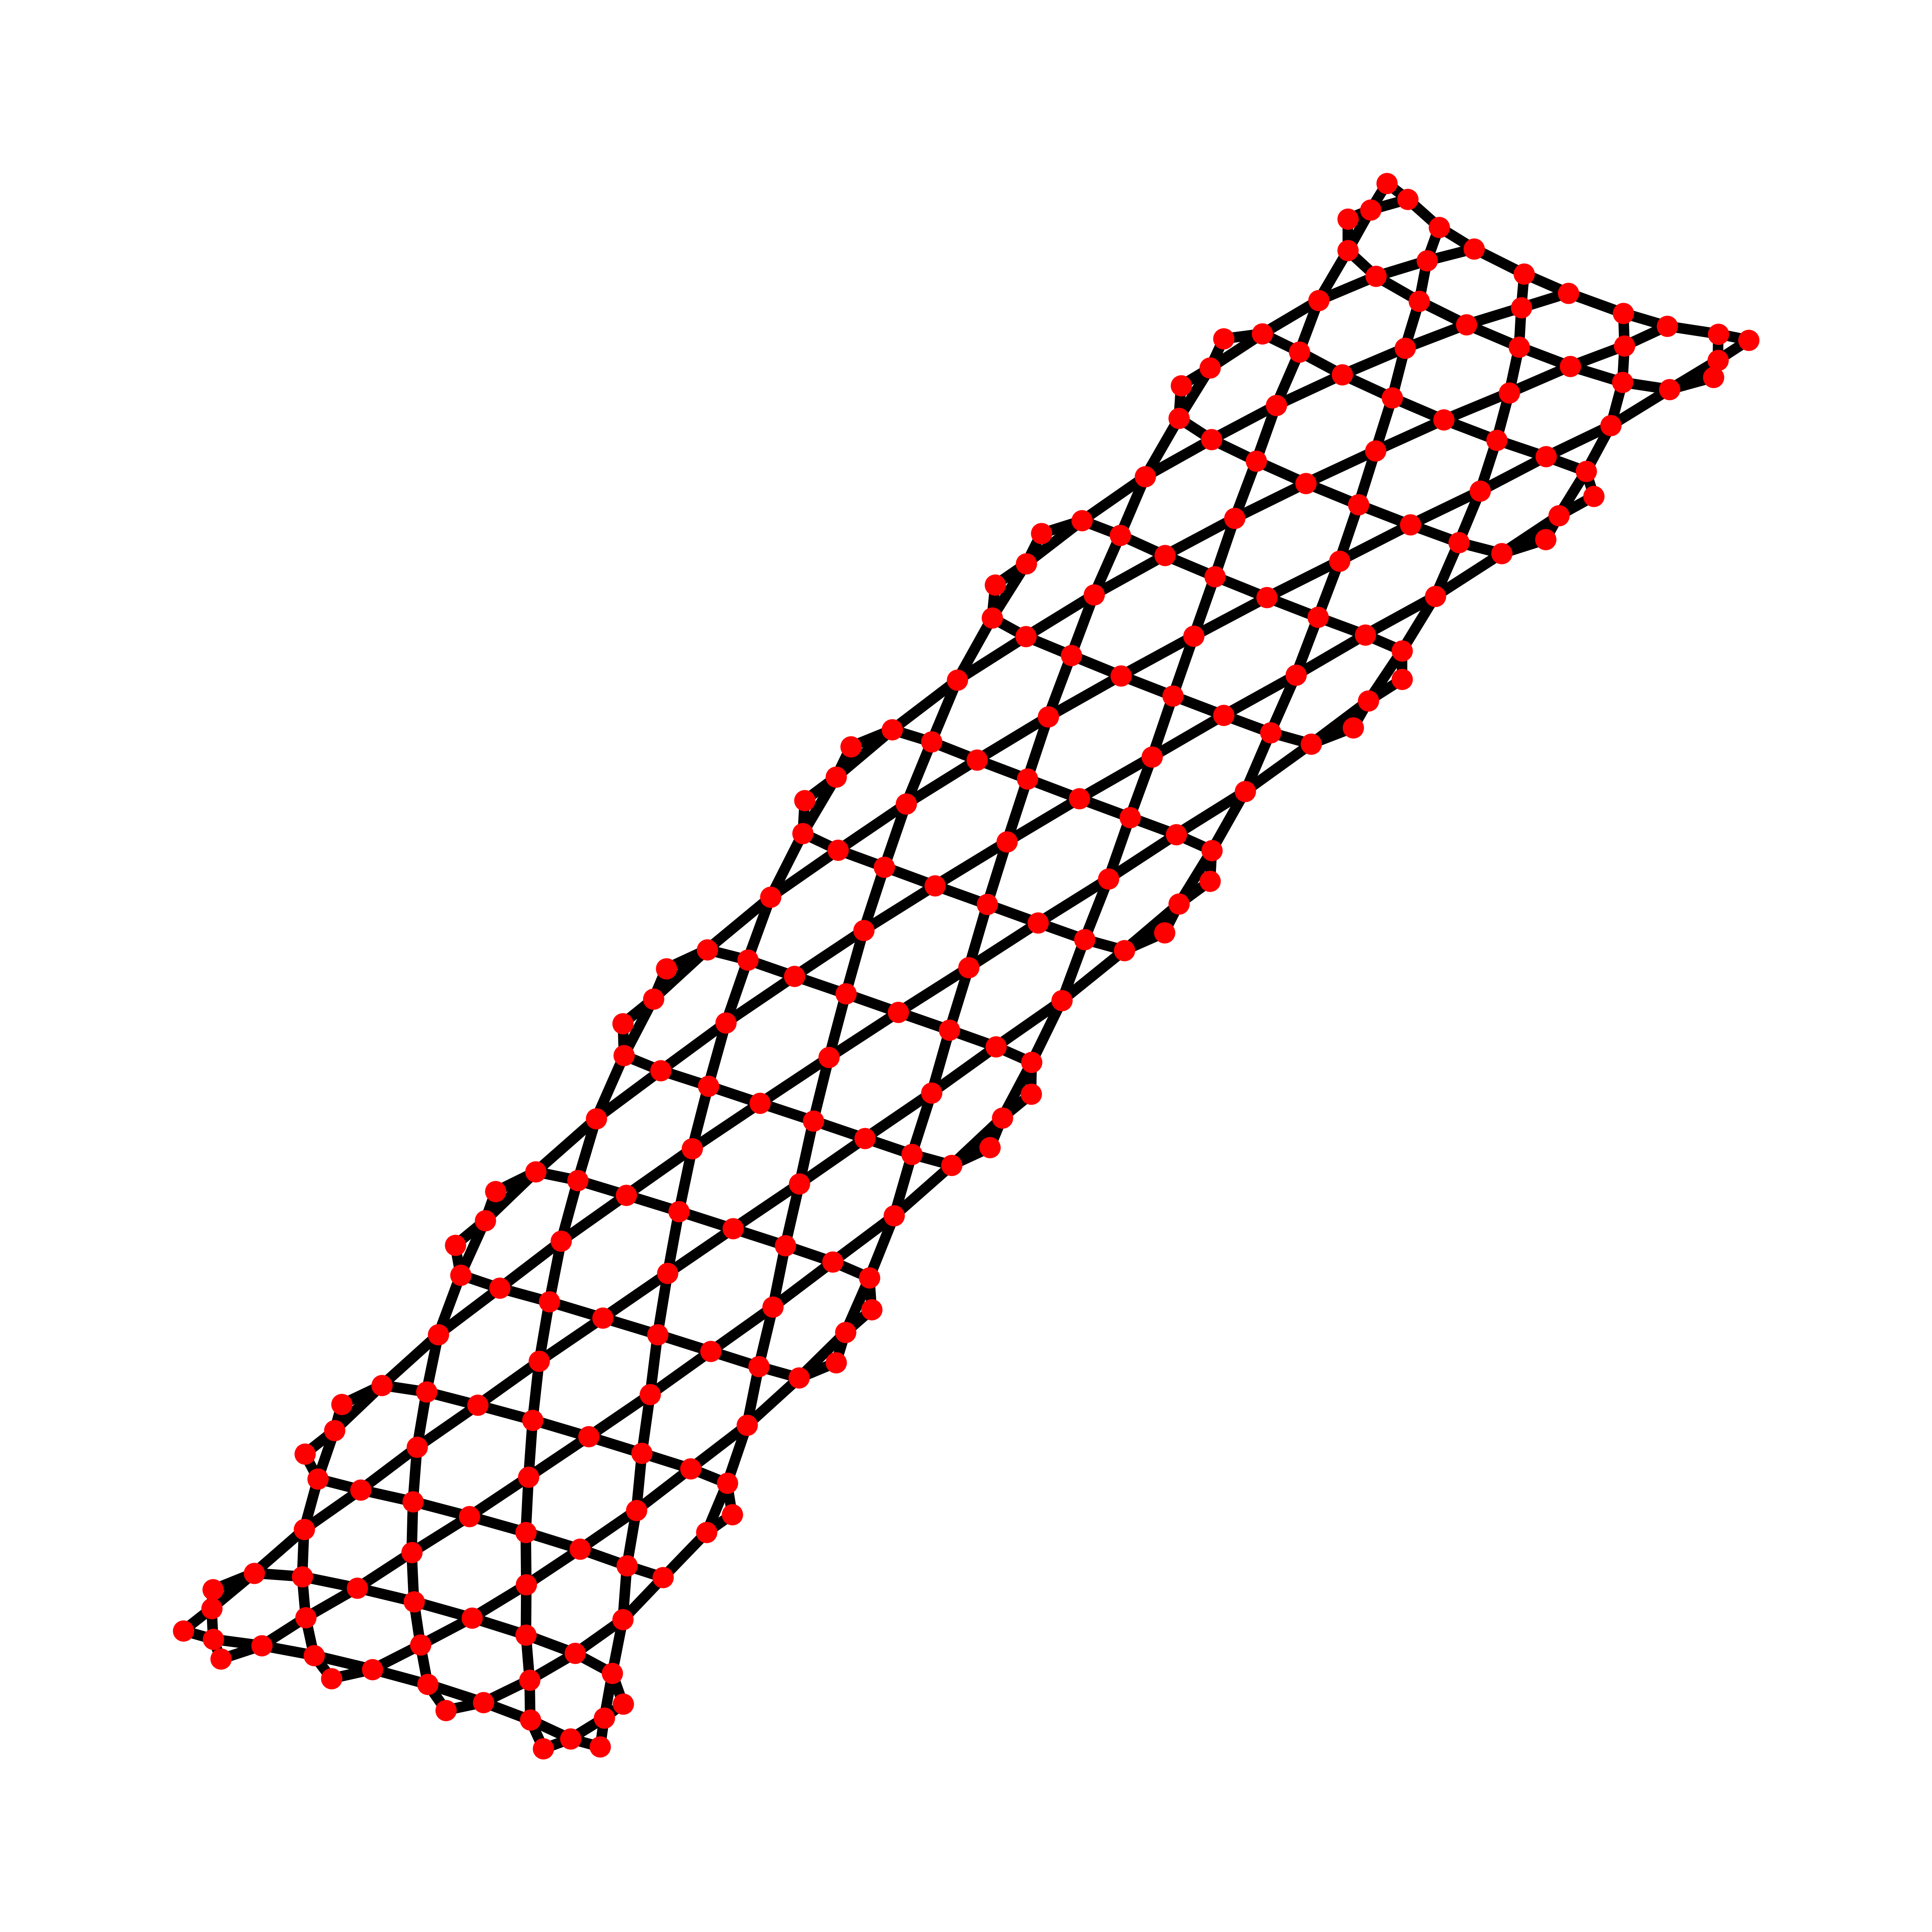

In [36]:
#make a graph with majority rule, for the fourier transform. 
#for all pre-imposed two-chains, remove the second one, reconnect to other sites
#then cut open the periodic boundary condition
simplify_Kag_graph = nx.Graph()

all_edges_kag = []
for m in nodes_class.keys():
    simplify_Kag_graph.add_node(m)
for e in coups_class.keys():
    simplify_Kag_graph.add_edge(*e)
    all_edges_kag.append(e)

to_add_edge = [(336,8), (336,12), (400,9), (400,13), (464,10), (464,14), (528,11), (528,15)]

#remove the end edges
for e in all_edges_kag:
    if e in to_add_edge:
        simplify_Kag_graph.remove_edge(*e)
    elif Reverse(e) in to_add_edge:
        simplify_Kag_graph.remove_edge(*Reverse(e))


#remove the second site of the two chains, and replug the graph
to_remove = []
to_add = []
node_remove = []
for twoch in twochains:
    #print("treating this 2chain", twoch)
    node_remove.append(twoch[1])
    temp_edges_to_modify = simplify_Kag_graph.edges(twoch[1])
    #print(temp_edges_to_modify)
    for edge in temp_edges_to_modify:
        #print("Modifying this edges", edge)
        to_remove.append(edge)
        if edge != twoch and edge != Reverse(twoch):
            new_link = twoch[1]
            for m in range(2):
                if edge[m] != twoch[1]:
                    new_link = edge[m]
            edge_add = (twoch[0], new_link)
            to_add.append(edge_add)


simplify_Kag_graph.remove_edges_from(to_remove)
simplify_Kag_graph.add_edges_from(to_add)
simplify_Kag_graph.remove_nodes_from(node_remove)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
test, planar_embed = nx.check_planarity(simplify_Kag_graph)
pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 5000, pos = pos, scale = 40)
nx.draw(simplify_Kag_graph, pos, node_size = 50, node_color = 'red', width = 4)
